# Model Performance Analysis

This notebook analyzes the evaluation results from different models and creates plots comparing their performance across various Signal-to-Noise Ratio (SNR) levels, similar to Figure 4 in the paper.


In [2]:
# Import required libraries
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

# Set figure parameters
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


In [3]:
# Define paths
evaluation_dir = Path('results/evaluation/evaluation')

# Define model files and their display names
model_files = {
    '3_FA_RoPE(64)_validation.xlsx': 'Edge-BS-RoFormer',
    '5_Baseline_dcunet_validation.xlsx': 'DCUNet',
    '7_Baseline_dptnet_validation.xlsx': 'DPTNet',
    '8_Baseline_htdemucs_validation.xlsx': 'HTDemucs'
}

# Color mapping (matching paper colors)
model_colors = {
    'Edge-BS-RoFormer': '#FF7F00',  # Orange
    'DCUNet': '#377EB8',              # Blue
    'DPTNet': '#E41A1C',              # Red
    'HTDemucs': '#4DAF4A'             # Green
}

print("Model files to analyze:")
for file, name in model_files.items():
    print(f"  {name}: {file}")


Model files to analyze:
  Edge-BS-RoFormer: 3_FA_RoPE(64)_validation.xlsx
  DCUNet: 5_Baseline_dcunet_validation.xlsx
  DPTNet: 7_Baseline_dptnet_validation.xlsx
  HTDemucs: 8_Baseline_htdemucs_validation.xlsx


In [4]:
# Load all Excel files
dataframes = {}

for filename, model_name in model_files.items():
    filepath = evaluation_dir / filename
    if filepath.exists():
        try:
            df = pd.read_excel(filepath)
            df['Model'] = model_name
            dataframes[model_name] = df
            print(f"✓ Loaded {model_name}: {len(df)} samples")
            print(f"  Columns: {list(df.columns)}")
            print(f"  SNR range: {df['Input_SNR'].min():.1f} to {df['Input_SNR'].max():.1f} dB")
            print()
        except Exception as e:
            print(f"✗ Error loading {filename}: {e}")
    else:
        print(f"✗ File not found: {filepath}")


✓ Loaded Edge-BS-RoFormer: 720 samples
  Columns: ['ID', 'Input_SNR', 'sdr', 'si_sdr', 'l1_freq', 'pesq', 'stoi', 'RTF', 'FLOPs_G', 'GPU_Mem_MB', 'Model']
  SNR range: -30.0 to inf dB

✓ Loaded DCUNet: 720 samples
  Columns: ['ID', 'Input_SNR', 'sdr', 'si_sdr', 'l1_freq', 'pesq', 'stoi', 'RTF', 'FLOPs_G', 'GPU_Mem_MB', 'Model']
  SNR range: -30.0 to inf dB

✓ Loaded DPTNet: 720 samples
  Columns: ['ID', 'Input_SNR', 'sdr', 'si_sdr', 'l1_freq', 'pesq', 'stoi', 'RTF', 'FLOPs_G', 'GPU_Mem_MB', 'Model']
  SNR range: -30.0 to inf dB

✓ Loaded HTDemucs: 720 samples
  Columns: ['ID', 'Input_SNR', 'sdr', 'si_sdr', 'l1_freq', 'pesq', 'stoi', 'RTF', 'FLOPs_G', 'GPU_Mem_MB', 'Model']
  SNR range: -30.0 to inf dB



In [5]:
# Combine all dataframes
if dataframes:
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    print(f"Total samples: {len(combined_df)}")
    print(f"\nModels: {combined_df['Model'].unique()}")
    print(f"\nSNR range: {combined_df['Input_SNR'].min():.1f} to {combined_df['Input_SNR'].max():.1f} dB")
    print(f"\nAvailable metrics: {[col for col in combined_df.columns if col in ['si_sdr', 'pesq', 'stoi', 'sdr']]}")

    # Display basic statistics
    print("\n" + "="*80)
    print("Summary Statistics by Model:")
    print("="*80)
    summary = combined_df.groupby('Model')[['si_sdr', 'pesq', 'stoi']].agg(['mean', 'std', 'count'])
    print(summary)


Total samples: 2880

Models: ['Edge-BS-RoFormer' 'DCUNet' 'DPTNet' 'HTDemucs']

SNR range: -30.0 to inf dB

Available metrics: ['sdr', 'si_sdr', 'pesq', 'stoi']

Summary Statistics by Model:
                     si_sdr                       pesq                  \
                       mean        std count      mean       std count   
Model                                                                    
DCUNet            -8.094279  11.270330   720  1.256453  0.555687   712   
DPTNet           -33.390892  11.210766   720  1.049752  0.072479   712   
Edge-BS-RoFormer  -9.934595   9.828736   720  1.329478  0.611772   712   
HTDemucs         -10.099518  12.832141   720  1.139266  0.213864   712   

                      stoi                  
                      mean       std count  
Model                                       
DCUNet            0.541400  0.244120   720  
DPTNet            0.302136  0.145665   720  
Edge-BS-RoFormer  0.528841  0.239124   720  
HTDemucs          0.

In [6]:
# Prepare data for plotting
# Group by SNR bins (similar to paper: -30 to 0 dB in steps)
snr_bins = np.arange(-30, 5, 5)  # -30, -25, -20, -15, -10, -5, 0

# Create SNR bin labels
combined_df['SNR_bin'] = pd.cut(
    combined_df['Input_SNR'],
    bins=snr_bins,
    labels=[f"{int(b)}" for b in snr_bins[:-1]],
    include_lowest=True
)

# Also create continuous SNR for smoother plots
# Group by model and SNR, calculate mean and std
metrics_to_plot = ['si_sdr', 'stoi', 'pesq']

# Calculate statistics by SNR bin
plot_data = {}
for metric in metrics_to_plot:
    plot_data[metric] = {}
    for model_name in combined_df['Model'].unique():
        model_data = combined_df[combined_df['Model'] == model_name].copy()

        # Group by SNR bin
        grouped = model_data.groupby('SNR_bin')[metric].agg(['mean', 'std', 'count'])

        # Extract SNR values and metrics
        snr_values = []
        metric_means = []
        metric_stds = []

        for snr_bin in grouped.index:
            if pd.notna(snr_bin):
                snr_val = int(snr_bin)
                mean_val = grouped.loc[snr_bin, 'mean']
                std_val = grouped.loc[snr_bin, 'std']
                # Only add if we have valid data
                if pd.notna(mean_val):
                    snr_values.append(snr_val)
                    metric_means.append(mean_val)
                    metric_stds.append(std_val if pd.notna(std_val) else 0)

        # Sort by SNR for proper plotting
        if snr_values:
            sorted_indices = np.argsort(snr_values)
            plot_data[metric][model_name] = {
                'snr': [snr_values[i] for i in sorted_indices],
                'mean': [metric_means[i] for i in sorted_indices],
                'std': [metric_stds[i] for i in sorted_indices]
            }
        else:
            plot_data[metric][model_name] = {
                'snr': [],
                'mean': [],
                'std': []
            }

print("Data prepared for plotting")
for metric in metrics_to_plot:
    print(f"\n{metric.upper()}:")
    for model_name in plot_data[metric].keys():
        num_points = len(plot_data[metric][model_name]['snr'])
        print(f"  {model_name}: {num_points} SNR points")
        if num_points > 0:
            snr_range = f"{plot_data[metric][model_name]['snr'][0]} to {plot_data[metric][model_name]['snr'][-1]} dB"
            print(f"    SNR range: {snr_range}")


Data prepared for plotting

SI_SDR:
  Edge-BS-RoFormer: 6 SNR points
    SNR range: -30 to -5 dB
  DCUNet: 6 SNR points
    SNR range: -30 to -5 dB
  DPTNet: 6 SNR points
    SNR range: -30 to -5 dB
  HTDemucs: 6 SNR points
    SNR range: -30 to -5 dB

STOI:
  Edge-BS-RoFormer: 6 SNR points
    SNR range: -30 to -5 dB
  DCUNet: 6 SNR points
    SNR range: -30 to -5 dB
  DPTNet: 6 SNR points
    SNR range: -30 to -5 dB
  HTDemucs: 6 SNR points
    SNR range: -30 to -5 dB

PESQ:
  Edge-BS-RoFormer: 6 SNR points
    SNR range: -30 to -5 dB
  DCUNet: 6 SNR points
    SNR range: -30 to -5 dB
  DPTNet: 6 SNR points
    SNR range: -30 to -5 dB
  HTDemucs: 6 SNR points
    SNR range: -30 to -5 dB


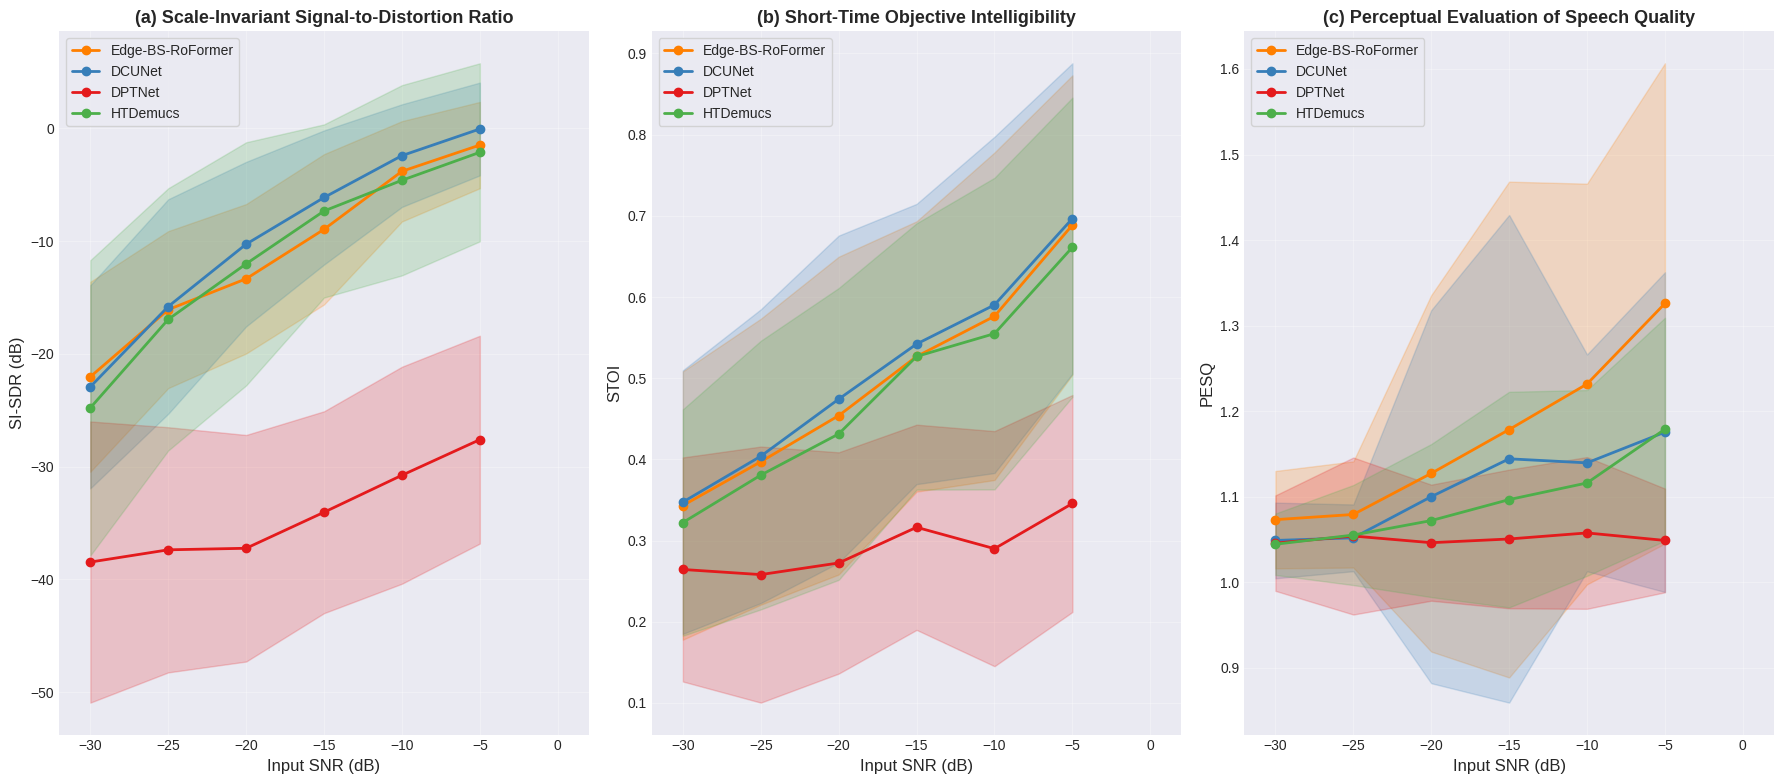

Plot saved to: results/evaluation/model_comparison.png


In [8]:
# Create plots similar to Figure 4 in the paper
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Plot 1: SI-SDR
ax1 = axes[0]
for model_name in model_colors.keys():
    if model_name in plot_data['si_sdr']:
        data = plot_data['si_sdr'][model_name]
        if len(data['snr']) > 0 and len(data['mean']) > 0:
            # Filter out NaN values
            valid_mask = [pd.notna(m) for m in data['mean']]
            if any(valid_mask):
                snr_vals = [data['snr'][i] for i in range(len(data['snr'])) if valid_mask[i]]
                mean_vals = [data['mean'][i] for i in range(len(data['mean'])) if valid_mask[i]]
                std_vals = [data['std'][i] if pd.notna(data['std'][i]) else 0
                           for i in range(len(data['std'])) if valid_mask[i]]

                ax1.plot(snr_vals, mean_vals,
                        marker='o', linewidth=2, markersize=6,
                        label=model_name, color=model_colors[model_name])
                # Add error bars (standard deviation)
                ax1.fill_between(snr_vals,
                                np.array(mean_vals) - np.array(std_vals),
                                np.array(mean_vals) + np.array(std_vals),
                                alpha=0.2, color=model_colors[model_name])

ax1.set_xlabel('Input SNR (dB)', fontsize=12)
ax1.set_ylabel('SI-SDR (dB)', fontsize=12)
ax1.set_title('(a) Scale-Invariant Signal-to-Distortion Ratio', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', frameon=True)
ax1.set_xlim(-32, 2)

# Plot 2: STOI
ax2 = axes[1]
for model_name in model_colors.keys():
    if model_name in plot_data['stoi']:
        data = plot_data['stoi'][model_name]
        if len(data['snr']) > 0 and len(data['mean']) > 0:
            # Filter out NaN values
            valid_mask = [pd.notna(m) for m in data['mean']]
            if any(valid_mask):
                snr_vals = [data['snr'][i] for i in range(len(data['snr'])) if valid_mask[i]]
                mean_vals = [data['mean'][i] for i in range(len(data['mean'])) if valid_mask[i]]
                std_vals = [data['std'][i] if pd.notna(data['std'][i]) else 0
                           for i in range(len(data['std'])) if valid_mask[i]]

                ax2.plot(snr_vals, mean_vals,
                        marker='o', linewidth=2, markersize=6,
                        label=model_name, color=model_colors[model_name])
                # Add error bars
                ax2.fill_between(snr_vals,
                                np.array(mean_vals) - np.array(std_vals),
                                np.array(mean_vals) + np.array(std_vals),
                                alpha=0.2, color=model_colors[model_name])

ax2.set_xlabel('Input SNR (dB)', fontsize=12)
ax2.set_ylabel('STOI', fontsize=12)
ax2.set_title('(b) Short-Time Objective Intelligibility', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', frameon=True)
ax2.set_xlim(-32, 2)

# Plot 3: PESQ
ax3 = axes[2]
for model_name in model_colors.keys():
    if model_name in plot_data['pesq']:
        data = plot_data['pesq'][model_name]
        if len(data['snr']) > 0 and len(data['mean']) > 0:
            # Filter out NaN values
            valid_mask = [pd.notna(m) for m in data['mean']]
            if any(valid_mask):
                snr_vals = [data['snr'][i] for i in range(len(data['snr'])) if valid_mask[i]]
                mean_vals = [data['mean'][i] for i in range(len(data['mean'])) if valid_mask[i]]
                std_vals = [data['std'][i] if pd.notna(data['std'][i]) else 0
                           for i in range(len(data['std'])) if valid_mask[i]]

                ax3.plot(snr_vals, mean_vals,
                        marker='o', linewidth=2, markersize=6,
                        label=model_name, color=model_colors[model_name])
                # Add error bars
                ax3.fill_between(snr_vals,
                                np.array(mean_vals) - np.array(std_vals),
                                np.array(mean_vals) + np.array(std_vals),
                                alpha=0.2, color=model_colors[model_name])

ax3.set_xlabel('Input SNR (dB)', fontsize=12)
ax3.set_ylabel('PESQ', fontsize=12)
ax3.set_title('(c) Perceptual Evaluation of Speech Quality', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best', frameon=True)
ax3.set_xlim(-32, 2)

plt.tight_layout()
# Ensure directory exists
Path('results/evaluation').mkdir(parents=True, exist_ok=True)
plt.savefig('results/evaluation/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: results/evaluation/model_comparison.png")



Performance Analysis at -15 dB SNR (±2 dB)
                     si_sdr                      pesq                  \
                       mean       std count      mean       std count   
Model                                                                   
DCUNet            -7.645267  6.345396   100  1.140515  0.299855   100   
DPTNet           -35.571804  9.636789   100  1.056446  0.105365   100   
Edge-BS-RoFormer -11.664799  7.166918   100  1.141024  0.259474   100   
HTDemucs          -9.097313  7.942107   100  1.078178  0.089124   100   

                      stoi                  
                      mean       std count  
Model                                       
DCUNet            0.511100  0.187758   100  
DPTNet            0.306963  0.123481   100  
Edge-BS-RoFormer  0.495728  0.180173   100  
HTDemucs          0.485929  0.176387   100  


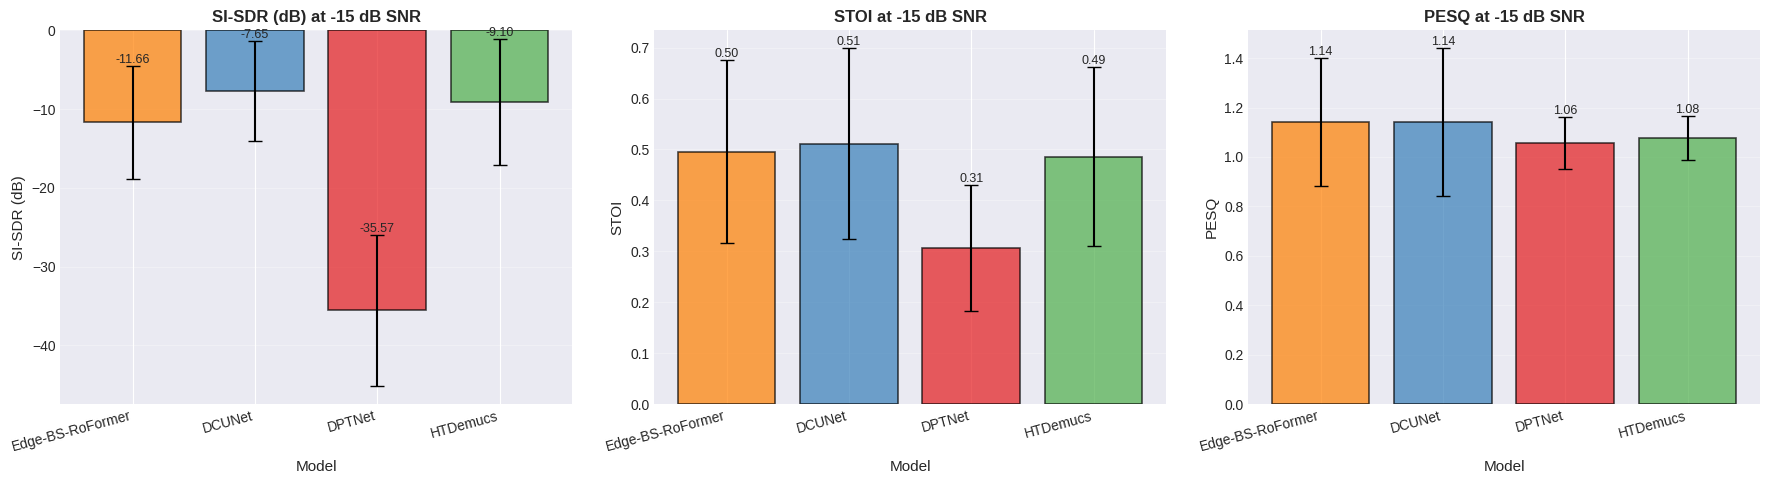


Plot saved to: results/evaluation/performance_at_-15dB.png


In [9]:
# Create a more detailed analysis: Performance at specific SNR levels
# Focus on -15 dB as mentioned in the paper
target_snr = -15
snr_tolerance = 2  # ±2 dB tolerance

print(f"\n{'='*80}")
print(f"Performance Analysis at {target_snr} dB SNR (±{snr_tolerance} dB)")
print(f"{'='*80}")

snr_filtered = combined_df[
    (combined_df['Input_SNR'] >= target_snr - snr_tolerance) &
    (combined_df['Input_SNR'] <= target_snr + snr_tolerance)
]

if len(snr_filtered) > 0:
    summary_at_snr = snr_filtered.groupby('Model')[['si_sdr', 'pesq', 'stoi']].agg(['mean', 'std', 'count'])
    print(summary_at_snr)

    # Create a bar plot for comparison at -15 dB
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    metrics = ['si_sdr', 'stoi', 'pesq']
    metric_labels = ['SI-SDR (dB)', 'STOI', 'PESQ']

    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx]
        means = []
        stds = []
        model_names = []
        colors_list = []

        for model_name in model_colors.keys():
            model_data = snr_filtered[snr_filtered['Model'] == model_name]
            if len(model_data) > 0 and metric in model_data.columns:
                valid_data = model_data[metric].dropna()
                if len(valid_data) > 0:
                    means.append(valid_data.mean())
                    stds.append(valid_data.std())
                    model_names.append(model_name)
                    colors_list.append(model_colors[model_name])

        if means:
            x_pos = np.arange(len(model_names))
            bars = ax.bar(x_pos, means, yerr=stds, capsize=5,
                        color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.2)
            ax.set_xlabel('Model', fontsize=11)
            ax.set_ylabel(label, fontsize=11)
            ax.set_title(f'{label} at {target_snr} dB SNR', fontsize=12, fontweight='bold')
            ax.set_xticks(x_pos)
            ax.set_xticklabels(model_names, rotation=15, ha='right')
            ax.grid(True, alpha=0.3, axis='y')

            # Add value labels on bars
            for i, (bar, mean_val) in enumerate(zip(bars, means)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + stds[i] if stds[i] > 0 else height,
                       f'{mean_val:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(f'results/evaluation/performance_at_{target_snr}dB.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\nPlot saved to: results/evaluation/performance_at_{target_snr}dB.png")
else:
    print(f"No data found for SNR around {target_snr} dB")


In [10]:
# Create a comprehensive summary table
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)

# Calculate statistics across all SNR levels
summary_all = combined_df.groupby('Model').agg({
    'si_sdr': ['mean', 'std', 'min', 'max'],
    'pesq': ['mean', 'std', 'min', 'max'],
    'stoi': ['mean', 'std', 'min', 'max'],
    'Input_SNR': ['mean', 'min', 'max']
}).round(3)

print("\nOverall Performance (All SNR levels):")
print(summary_all)

# Save summary to CSV
summary_all.to_csv('results/evaluation/performance_summary.csv')
print("\nSummary saved to: results/evaluation/performance_summary.csv")



COMPREHENSIVE PERFORMANCE SUMMARY

Overall Performance (All SNR levels):
                  si_sdr                           pesq                       \
                    mean     std     min     max   mean    std    min    max   
Model                                                                          
DCUNet            -8.094  11.270 -42.818  16.362  1.256  0.556  1.018  4.344   
DPTNet           -33.391  11.211 -71.630  -4.011  1.050  0.072  1.017  1.854   
Edge-BS-RoFormer  -9.935   9.829 -50.020  11.486  1.329  0.612  1.020  4.181   
HTDemucs         -10.100  12.832 -71.098  12.581  1.139  0.214  1.017  2.578   

                   stoi                      Input_SNR              
                   mean    std    min    max      mean    min  max  
Model                                                               
DCUNet            0.541  0.244 -0.015  0.989       inf -29.96  inf  
DPTNet            0.302  0.146 -0.120  0.702       inf -29.96  inf  
Edge-BS-RoFormer  0.

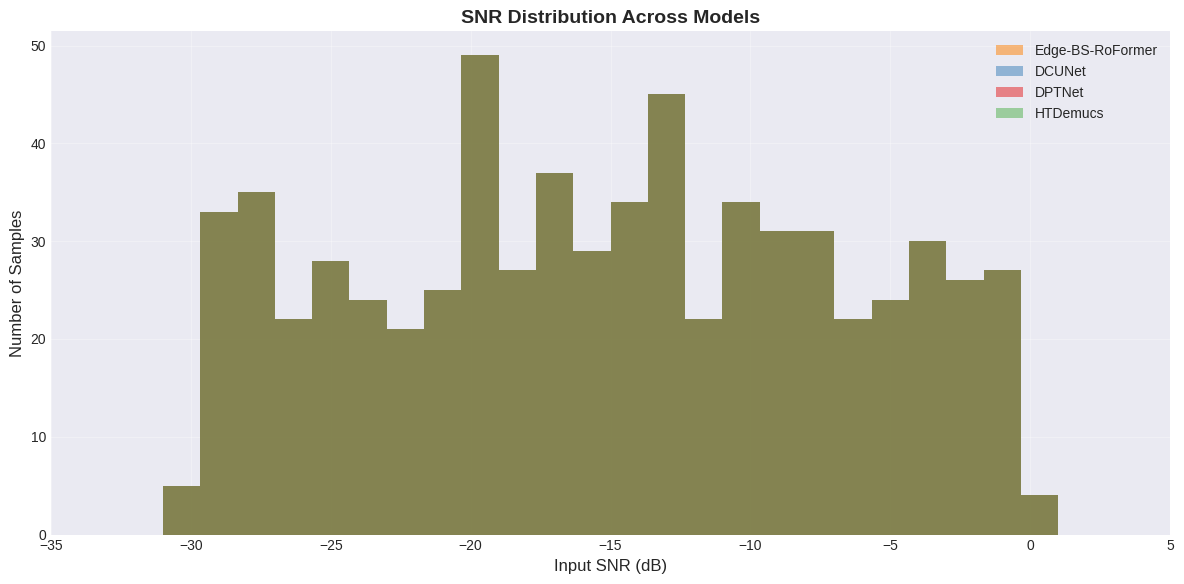

SNR distribution plot saved to: results/evaluation/snr_distribution.png


In [12]:
# Additional analysis: SNR distribution
fig, ax = plt.subplots(figsize=(12, 6))

for model_name in model_colors.keys():
    model_data = combined_df[combined_df['Model'] == model_name]
    if len(model_data) > 0:
        ax.hist(model_data['Input_SNR'], bins=30, alpha=0.5,
               label=model_name, color=model_colors[model_name])

ax.set_xlabel('Input SNR (dB)', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('SNR Distribution Across Models', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/evaluation/snr_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("SNR distribution plot saved to: results/evaluation/snr_distribution.png")
